In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from pmdarima import auto_arima
# Suppress warnings (optional)
warnings.filterwarnings("ignore")

In [2]:
# ─── Config ────────────────────────────────────────────────────────────────────
DATA_PATH   = '../../Data/DM/train_cleaned.csv'
MODEL_DIR   = './models'
MODEL_PATH  = os.path.join(MODEL_DIR, 'sarimax_AUTOMOTIVE.pkl')
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:
# ─── 1. Load & Preprocess ───────────────────────────────────────────────────────
df = pd.read_csv(DATA_PATH, parse_dates=['date'])
df.drop(columns=['id'], inplace=True)
df = df[df['family']=='AUTOMOTIVE']

# aggregate daily across all stores
autodf = (
    df
    .groupby('date')[['sales','onpromotion']]
    .sum()
)
autodf.index = pd.DatetimeIndex(autodf.index).to_period('D')
autodf['y']  = np.log1p(autodf['sales'])

# keep 2017+ for plotting
autoplot = autodf.loc[autodf.index.to_timestamp() >= '2017-01-01']

In [4]:
# ─── 3. Auto-ARIMA order selection (once) ───────────────────────────────────────
stepwise = auto_arima(
    autodf['y'],
    seasonal=True, m=7,
    start_p=0, start_q=0, max_p=5, max_q=5,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    d=None, D=None,
    trace=True,
    suppress_warnings=True,
    error_action='ignore'
)
order          = stepwise.order
seasonal_order = stepwise.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1940.456, Time=0.27 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1491.233, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=976.717, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1938.456, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1167.466, Time=0.73 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.71 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=875.261, Time=6.75 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.24 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=1767.526, Time=0.74 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=7.91 sec
 ARIMA(0,1,2)(0,0,2)[7] intercept   : AIC=848.124, Time=8.30 sec
 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=932.686, Time=2.68 sec
 ARIMA(0,1,2)(1,0,2)[7] intercept   : AIC=615.121, Time=10.92 sec
 ARIMA(0,1,2)(1,0,1)[7] intercept   : AIC=535.673, Time=2.84 sec
 ARIMA(0,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=

In [5]:
# ─── 4. Load or Fit & Save SARIMAX ──────────────────────────────────────────────
if os.path.exists(MODEL_PATH):
    print("Loading saved model…")
    fit = SARIMAXResults.load(MODEL_PATH)
else:
    print("Fitting new model…")
    model = SARIMAX(
        autodf['y'],
        exog=autodf[['onpromotion']],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fit = model.fit(disp=False)
    fit.save(MODEL_PATH)
    print(f"Model saved to {MODEL_PATH!r}")

Fitting new model…
Model saved to './models\\sarimax_AUTOMOTIVE.pkl'


In [6]:
# ─── 5. Forecast last 14 days ───────────────────────────────────────────────────
n_test    = 14
train     = autodf.iloc[:-n_test]
test      = autodf.iloc[-n_test:]
exog_test = test[['onpromotion']]

pred_log  = fit.get_forecast(steps=n_test, exog=exog_test).predicted_mean
pred      = np.expm1(pred_log)

In [7]:
# ─── 6. Compute Metrics ─────────────────────────────────────────────────────────
# RMSE
mse   = mean_squared_error(test['sales'], pred)
rmse  = np.sqrt(mse)

# MAE
mae   = mean_absolute_error(test['sales'], pred)

# R²
r2    = r2_score(test['sales'], pred)

# Mean daily sales (for relative RMSE)
mean_sales     = autodf['sales'].mean()
rel_rmse_pct   = 100 * rmse / mean_sales

# MAPE
mape = np.mean(np.abs((test['sales'] - pred) / test['sales'])) * 100

In [8]:
# ─── 7. Print Results ───────────────────────────────────────────────────────────
print(f"\nTest RMSE:           {rmse:.2f} units")
print(f"Mean daily sales:    {mean_sales:.2f} units")
print(f"Relative RMSE:       {rel_rmse_pct:.2f}% of mean sales")
print(f"MAPE:                {mape:.2f}%")
print(f"MAE:                 {mae:.2f} units")
print(f"R² (coefficient of determination): {r2:.3f}")


Test RMSE:           51.37 units
Mean daily sales:    329.66 units
Relative RMSE:       15.58% of mean sales
MAPE:                28.60%
MAE:                 42.32 units
R² (coefficient of determination): 0.608


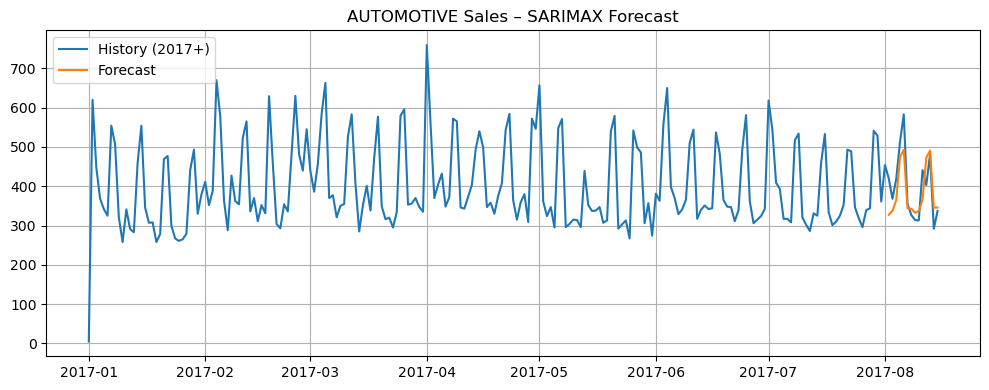

In [9]:
# ─── 8. Plot ────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10,4))
plt.plot(autoplot.index.to_timestamp(), np.expm1(autoplot['y']), label='History (2017+)')
plt.plot(test.index.to_timestamp(), pred,                  label='Forecast')
plt.legend(loc='upper left')
plt.title("AUTOMOTIVE Sales – SARIMAX Forecast")
plt.grid(True)
plt.tight_layout()
plt.show()